In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
%load_ext autoreload
%autoreload 2

Using device cpu


# 05c Single Cell Dataset Benchmarker
> Run a given model on all of our toy datasets (optionally, do so many times), and produce training gifs and loss charts for each.

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05c Single Cell Dataset Benchmarker.ipynb"
dataset_name = "bone marrow"
sigma = 'automatic'
flow_strength = 5
smoothness_weight = 0
flow_neighbor_loss_weight = 1
contrastive_flow_loss_weight = 5
diffdist_weight = 1
num_neighbors = 5

In [ ]:
# Parameters
notebook = "05c Single Cell Dataset Benchmarker.ipynb"
dataset_name = "bone marrow"
sigma = "automatic"
flow_strength = 1
smoothness_weight = 0
flow_neighbor_loss_weight = 10
contrastive_flow_loss_weight = 10
diffdist_weight = 1
num_neighbors = 5
output_label = "run_16"


# Set Up

Normalized count data: X, spliced, unspliced.
Logarithmized X.


computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding


    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


Set sigma =  4.438774


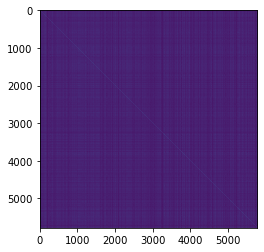

In [ ]:
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
# choose correct dataset
if dataset_name == "bone marrow":
    adata = scv.datasets.bonemarrow()
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
    
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma=sigma, dmap_coords_to_use=3, nbhd_strategy="flow neighbors", n_neighbors=num_neighbors, flow_strength = flow_strength)
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

In [ ]:
X.shape

torch.Size([5780, 30])

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = notebook.replace('.ipynb','')
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[30, 20, 10, 5, 2],
            device=device,
            sigma=1,
            flow_strength=5,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "diffusion map regularization": diffdist_weight,
            "kld": 0,
            "smoothness": smoothness_weight,
            "flow neighbor loss": flow_neighbor_loss_weight,
            "contrastive flow loss": contrastive_flow_loss_weight,
        }
visualization_functions = [
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=10)

  0%|                                                                                             | 0/10 [00:00<?, ?it/s]

 10%|████████▌                                                                            | 1/10 [00:19<02:55, 19.54s/it]

 20%|█████████████████                                                                    | 2/10 [00:38<02:32, 19.06s/it]

 30%|█████████████████████████▌                                                           | 3/10 [00:56<02:11, 18.85s/it]

 40%|██████████████████████████████████                                                   | 4/10 [01:15<01:53, 18.92s/it]

 50%|██████████████████████████████████████████▌                                          | 5/10 [01:34<01:34, 18.86s/it]

 60%|███████████████████████████████████████████████████                                  | 6/10 [01:53<01:14, 18.72s/it]

 70%|███████████████████████████████████████████████████████████▍                         | 7/10 [02:11<00:55, 18.63s/it]

 80%|████████████████████████████████████████████████████████████████████                 | 8/10 [02:29<00:36, 18.49s/it]

 90%|████████████████████████████████████████████████████████████████████████████▌        | 9/10 [02:48<00:18, 18.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:07<00:00, 18.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:07<00:00, 18.74s/it]

# Results

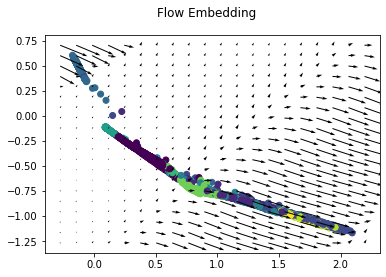

In [ ]:
FREDtrainer.visualize_embedding()

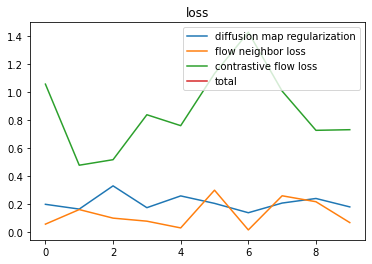

In [ ]:
FREDtrainer.visualize_loss()

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()
points_and_flows = np.concatenate([embedded_points, embedded_velocities], axis=1)
points_and_flows.shape

(5780, 4)

In [ ]:
import sklearn 
silhouette_points = sklearn.metrics.silhouette_score(embedded_points, labels)
silhouette_points_and_flows = sklearn.metrics.silhouette_score(points_and_flows, labels)

## Nearest Neighbors Classifier Score

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(points_and_flows, labels, test_size=0.33, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighClass = KNeighborsClassifier(n_neighbors=3)
neighClass.fit(X_train, y_train)
knn_classifier_score = neighClass.score(X_test, y_test)

In [ ]:
print(f"## SCORES ## \n silhouette score w/o flows: {silhouette_points}.\n silhouette score w/ flows:  {silhouette_points_and_flows} \n kNN Classifier {knn_classifier_score}")

## SCORES ## 
 silhouette score w/o flows: 0.2147427201271057.
 silhouette score w/ flows:  0.21472446620464325 
 kNN Classifier 0.7311320754716981


# Write results to spreadsheet

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
unid

'KAVCQPuK8F0VL1wHoH3J'

In [ ]:
import csv
spread_name = notebook.replace('.ipynb','')
print(spread_name)
with open(f"{spread_name}.csv", 'a') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(
        [unid, 
         sigma, 
         flow_strength, 
         flow_neighbor_loss_weight,
         smoothness_weight, 
         diffdist_weight, 
         silhouette_points,
         silhouette_points_and_flows,
         knn_classifier_score
        ]) 

05c Single Cell Dataset Benchmarker
